Output()

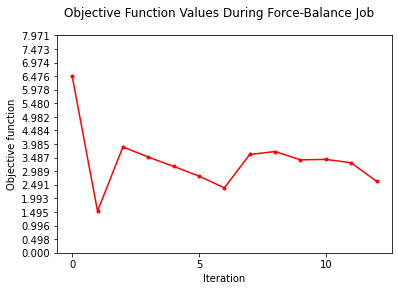

Output()

<Figure size 1296x864 with 0 Axes>

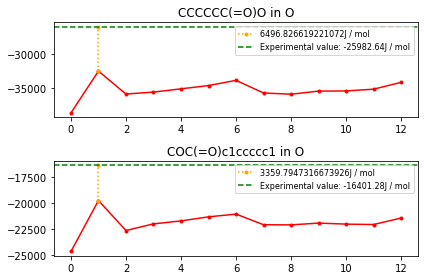

Output()

/var/folders/2h/qwnkzrws279__yz86krh0l_h0000gn/T/ipykernel_68246/1395968107.py:204: RuntimeWarning: invalid value encountered in true_divide
  plt.quiver(pos_x, pos_y, u/norm, v/norm, color='k', angles="xy", zorder=5, pivot="mid")


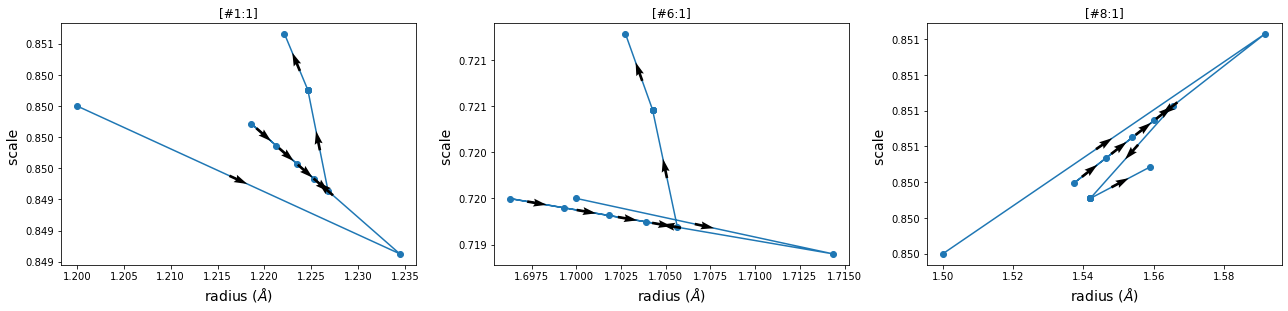

In [56]:
import pickle, gzip, json, os
import numpy as np
import matplotlib.pyplot as plt
import simtk.unit as simtk_unit
from openff.toolkit.typing.engines.smirnoff import ForceField
from matplotlib import patheffects
from matplotlib.ticker import FuncFormatter
from datetime import datetime
from rich.progress import track



#To use, place ForceBalance result directories of format "iter_0000", "iter_0001", etc in this notebook's directory
#If also graphing the experimental value in plot_properties, add the training_set.json file to the directory
#Leave the rest of the directory empty



#Count the folders in the current directory.
folders, files = 0, 0
path = os.getcwd()
for _, dirnames, filenames in os.walk(path):
    
    folders += len(dirnames)
    files += len(filenames)
    
    #Check if a training_set.json file is present as well -- needed to graph experimental data in plot_properties
    if 'training_set.json' in filenames:
        tset_json = True
    
    #If the notebook creates a checkpoints directory, don't count it as a FB results directory
    if '.ipynb_checkpoints' in dirnames:
        folders -= 1
    
    
#Plot the value of the objective function across all iterations
def plot_objective(savefig=False, author=None):
    
    #Obj is the value of the objective function
    obj = []
    
    #Open all objective.p files
    for i in track(range(folders)):
        with gzip.open(f"iter_{str(i).rjust(4,'0')}/objective.p",'rb') as f:

            temp_dict = pickle.load(f)
            obj.append(temp_dict['X'])
    
    #Create plot
    plt.plot(obj, 'r.-')
    
    #Cosmetic options
    plt.xticks(np.arange(0, folders, step=5))
    plt.yticks(np.arange(0, max(obj)+min(obj), step=max(obj)/len(obj)))
    suptitle = "Objective Function Values During Force-Balance Job"
    plt.suptitle(suptitle)
    title = ""
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function")

    #If requested, save the figure
    if savefig:
        now = datetime.now()
        plt.savefig('objective_results.png', dpi=400, transparent=False, facecolor='white', metadata={'title':title, 'author':author, 'date':str(now)})

    plt.show()
    
    
    
#Plot the values of all properties across all iterations
def plot_properties(expt=True, show_worst=False, show_best=True, savefig=False, author=None):
    
    values = []
    units = []

    for i in track(range(0,folders)):
        with open(f"iter_{str(i).rjust(4,'0')}/results.json","r") as f:

            temp_dict = json.load(f)
            num_properties = len(temp_dict["estimated_properties"]["properties"])

            if i == 0:
                for j in range(0, num_properties):
                    values.append([])

            for j in range(0, num_properties):

                #Add values of each property to a list inside the master list "values"
                values[j].append(temp_dict["estimated_properties"]["properties"][j]["value"]["value"])
                units.append(temp_dict["estimated_properties"]["properties"][j]["value"]["unit"])
    
    if expt:
        
        if tset_json:
            
            expt_val = []
            expt_unit = []
            
            for i in range(0, num_properties):
                with open("training_set.json") as f:
                    
                    training_set = json.load(f)
                    expt_val.append(training_set["properties"][i]["value"]["value"])
                    expt_unit.append(training_set["properties"][i]["value"]["unit"])
            
        else:
            
            print("A training_set.json file must be present to graph experimental data in plot_properties.")
            pass
    
    #If the experimental units are different than the evaluated units, change experimental units to evaluated units
    #Currently only supports kJ/mol and J/mol
    for i in range(0, num_properties):
        
        if str(units[i]) is not str(expt_unit[i]):

            if str(units[i]).replace(' ', '') == 'J/mol' and str(expt_unit[i]).replace(' ', '') == 'kJ/mol':
                expt_val[i] *= 1000
                expt_unit[i] = units[i]
            elif str(units[i]).replace(' ', '') == 'kJ/mol' and str(expt_unit[i]).replace(' ', '') == 'J/mol':
                expt_val[i] *= 1/1000
                expt_unit[i] = units[i]
    
    
    #For debugging, uncomment this line and view the dictionary:
    #print(json.dumps(temp_dict,indent=4))
    
    
    plt.figure(figsize=(18,12))
    #Subplot layout
    figure, axis = plt.subplots(num_properties)
    
    for i in range(0,num_properties):

        axis[i].plot(values[i], 'r.-')
        
        for j in range(0,len(values[i])):

            if show_worst and min(values[i]) == values[i][j]:
                if expt:
                    axis[i].plot([j,j], [values[i][j], expt_val[i]], '.:', color='orange', label=str(expt_val[i] - values[i][j]) + str(expt_unit[i]))
                else:
                    print("Experimental value necessary to plot the worst difference.")
                    pass

            if show_best and max(values[i]) == values[i][j]:
                if expt:
                    axis[i].plot([j,j], [values[i][j], expt_val[i]], '.:', color='orange', label=str(expt_val[i] - values[i][j]) + str(expt_unit[i]))
                else:
                    print("Experimental value necessary to plot the best difference.")
                    pass
            
        if expt:
            axis[i].axhline(y = expt_val[i], color = 'g', linestyle = 'dashed', label="Experimental value: "+str(expt_val[i])+str(expt_unit[i]))
        
        axis[i].set_title(temp_dict["estimated_properties"]["properties"][i]["substance"]["components"][1]["smiles"] + " in " + temp_dict["estimated_properties"]["properties"][i]["substance"]["components"][0]["smiles"])
        axis[i].legend(loc='best', fontsize=8)
        
    plt.tight_layout()
        
    #If requested, save the figure
    if savefig:
        now = datetime.now()
        title = ""
        plt.savefig('property_results.png', dpi=400, transparent=False, facecolor='white', metadata={'title':title, 'author':author, 'date':str(now)})

    plt.show()


    
def plot_parameters(savefig=False, author=None):
    
    #Place your parameters' SMIRKS here. Currently manual, needs to be automated
    atom_type = ['[#1:1]', '[#6:1]', '[#8:1]']
    radius = {'[#1:1]':[], '[#6:1]':[], '[#8:1]':[]}
    scale = {'[#1:1]':[], '[#6:1]':[], '[#8:1]':[]}
    
    
    for i in track(range(0,folders)):    
        force_field = ForceField(
                f"iter_{str(i).rjust(4,'0')}/openff-2.0.0-GBSA_OBC2-tagged.offxml", allow_cosmetic_attributes=True
            )
        
        for atype in atom_type:
                
            radius[atype].append(force_field.get_parameter_handler("GBSA")[atype].radius.value_in_unit(simtk_unit.angstrom))
            scale[atype].append(force_field.get_parameter_handler("GBSA")[atype].scale)
    
    plt.figure(figsize=(18,12))
    
    for i, atype in enumerate(atom_type):
        
        #plt.figure(figsize=(9,6))
        
        ax = plt.subplot(3,3,i+1)
        u = np.diff(radius[atype])
        v = np.diff(scale[atype])
        pos_x = radius[atype][:-1] + u/2
        pos_y = scale[atype][:-1] + v/2
        norm = np.sqrt(u**2+v**2) 

        plt.plot(radius[atype], scale[atype], "o-",label=atype)
        plt.quiver(pos_x, pos_y, u/norm, v/norm, color='k', angles="xy", zorder=5, pivot="mid")

        def format_tick_labels(x, pos):
            return '{0:.3f}'.format(x)

        ax.yaxis.set_major_formatter(FuncFormatter(format_tick_labels))
        plt.ylabel("scale ", fontsize=14)
        plt.xlabel("radius ($\AA$)", fontsize=14)
        plt.title(f"{atype}")
        plt.tight_layout()

    #If requested, save the figure
    if savefig:
        now = datetime.now()
        title = "Parameter Results"
        plt.savefig('parameter_results.png', dpi=500, transparent=False, facecolor='white', metadata={'title':title, 'author':author, 'date':str(now)})    
        
    
    plt.show()
    
    

#savefig=True
plot_objective()
plot_properties()
plot_parameters()